# Preparations

In [1]:
import sys
import math
import copy
import itertools
import numpy as np

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (5, 5)
from matplotlib.mlab import griddata

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate

# Settings

In [2]:
# Doesn't do anything now except affect filenames
main_mode = 'vanilla'

# Interpolation in final plot. If both are False, use a linear interpolator.
interpolation_method = 'linear'

# Which benchmark point to use
use_not_trained_benchmark = True

scatter_alpha=0.5

In [3]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

print(thetas[theta1])
print(thetas[theta_benchmark])

X_observed = np.load('../data/unweighted_events/X_test.npy')

[0.39293227 0.43229216]
[-0.5 -0.5]


In [4]:
colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

# Define strategies and load results

In [5]:
labels = []
suffices = []
folders = []

truth_index = 0
panel_indices = ([], [], [], []) # Usually, use four panels

expected_llr = []
p_values = []
q_medians = []
q_thresholds = []
q_threshold_uncertainties = []

r_benchmark = []
p0_benchmark = []
p1 = []
scores_benchmark = []
r_roam = []

def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 panel=-1, try_scores=True, is_truth=False, fix_exp=False):
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
        
        if fix_exp:
            _r_benchmark = np.exp(_r_benchmark)
            
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _p_values = _load('p_values_' + suffix, folder)
        _q_thresholds = _load('neyman_qcut_' + suffix, folder)
        _q_threshold_uncertainties = _load('neyman_qcut_uncertainties_' + suffix, folder)
        _q_medians = _load('neyman_qmedian_' + suffix, folder)
        do_neyman = True
        
        assert np.all(np.isfinite(_q_thresholds)), 'q thresholds contain NaNs'
        assert np.all(np.isfinite(_q_medians)), 'q medians contain NaNs'
        assert np.all(np.isfinite(_q_threshold_uncertainties)), 'q threshold uncertainties contain NaNs'
        
    except IOError:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
        
    except AssertionError as err:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
    
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
        
    try:
        _p1 = _load('p1_test', '../data/unweighted_events/')
        _p0_benchmark = _p1 * _r_benchmark
        do_densities = True
    except IOError:
        _p1 = None
        _p0_benchmark = None
        do_densities = False
    
    if try_scores:
        try:
            _scores_benchmark = _load('scores_' + benchmark_name + '_' + suffix, folder)
            do_scores = True
        except IOError:
            _scores_benchmark = None
            do_scores = False
    else:
        _scores_benchmark = None
        do_scores = False
        
    labels.append(label)
    suffices.append(suffix)
    
    expected_llr.append(_expected_llr)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    
    r_benchmark.append(_r_benchmark)
    p1.append(_p1)
    p0_benchmark.append(_p0_benchmark)
    scores_benchmark.append(_scores_benchmark)
    r_roam.append(_r_roam)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    if panel >= 0 and panel < 4:
        panel_indices[panel].append(index)
        
    if do_neyman or do_roaming or do_scores or do_densities:
        supported = []
        if do_neyman:
            supported.append('Neyman construction')
        if do_roaming:
            supported.append('x dependence plots')
        if do_scores:
            supported.append('score scatter plots')
        if do_densities:
            supported.append('densities')
        supported = ', '.join(supported)
            
        print('Loaded strategy ' + label + ' with support for ' + supported)
        
    else:
        print('Loaded strategy ' + label)
    

In [6]:
add_strategy('truth', 'truth', 'truth', is_truth=True)

add_strategy('AFC, 2d', 'afc_2d', 'afc', panel=0, try_scores=False)
add_strategy('AFC, 5d', 'afc_5d', 'afc', panel=0, try_scores=False)

add_strategy('carl, PbP raw', 'carl', 'point_by_point', panel=0, try_scores=False)
add_strategy('carl, PbP cal.', 'carl_calibrated', 'point_by_point', panel=0, try_scores=False)

add_strategy('carl, param. raw', 'carl', 'parameterized', panel=0)
add_strategy('carl, param. cal.', 'carl_calibrated', 'parameterized', panel=0, try_scores=False)

add_strategy('carl + score, param. raw', 'combined', 'parameterized', panel=1)
add_strategy('carl + score, param. cal.', 'combined_calibrated', 'parameterized', panel=1, try_scores=False)

# add_strategy('SM score regr., local model', 'scoreregression', 'score_regression', panel=2, try_scores=False, fix_exp=True)
add_strategy('SM score regr., score cal.', 'scoreregression_score', 'score_regression', panel=2, try_scores=False)
add_strategy('SM score regr., dynamic score cal.', 'scoreregression_rotatedscore', 'score_regression', panel=2, try_scores=False)
add_strategy('SM score regr., score.theta cal.', 'scoreregression_scoretheta', 'score_regression', panel=2, try_scores=False)

#add_strategy('regression, PbP raw', 'regression', 'point_by_point', panel=3, try_scores=False)
add_strategy('ratio regr., param. raw', 'regression', 'parameterized', panel=3)
add_strategy('ratio regr. + score, param. raw', 'combinedregression', 'parameterized', panel=3)


Loaded strategy truth with support for Neyman construction, x dependence plots, score scatter plots, densities
Loaded strategy AFC, 2d with support for densities
Loaded strategy AFC, 5d with support for densities
Loaded strategy carl, PbP raw with support for densities
Loaded strategy carl, PbP cal. with support for densities
Loaded strategy carl, param. raw with support for x dependence plots, score scatter plots, densities
Loaded strategy carl, param. cal. with support for x dependence plots, densities
Loaded strategy carl + score, param. raw with support for x dependence plots, score scatter plots, densities
Loaded strategy carl + score, param. cal. with support for x dependence plots, densities
Loaded strategy SM score regr., score cal. with support for Neyman construction, densities
Loaded strategy SM score regr., dynamic score cal. with support for Neyman construction, densities
Loaded strategy SM score regr., score.theta cal. with support for Neyman construction, densities
Loade

# Interpolate LLR and p values

In [7]:
expected_llr_errors = [llr - expected_llr[truth_index] for llr in expected_llr]

In [8]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# interpolate
interpolated_p_values = []
interpolated_expected_llr = []
interpolated_expected_llr_mle = []

for p_vals, llr in zip(p_values, expected_llr):
    
    _llr, _mle = interpolate(thetas, llr, xx, yy, method=interpolation_method, subtract_min=True)
    if p_vals is not None:
        _p_vals, _ = interpolate(thetas, np.log(np.clip(p_vals,1.e-6, 1.)), xx, yy, method=interpolation_method)
        _p_vals = np.exp(_p_vals)
    else:
        _p_vals = None
    
    interpolated_p_values.append(_p_vals)
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)

In [25]:
# interpolate
interpolated_q_medians = []
interpolated_q_thresholds = []
interpolated_95cl_excluded = []

for qmed, qthresh, qthresh_err in zip(q_medians, q_thresholds, q_threshold_uncertainties):
    
    if qmed is None or qthresh is None or qthresh_err is None:
        interpolated_q_medians.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_95cl_excluded.append(None)
        continue
    
    try:
        _qthresh, _ = interpolate(thetas, qthresh, xx, yy, z_uncertainties_thetas=2*qthresh_err,
                                  method='gp',
                                  length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                  matern_exponent=2.5,
                                  noise_level=0.01)
        _qmed, _ = interpolate(thetas, qmed, xx, yy,
                                  method='gp',
                                  length_scale_default=0.1, length_scale_min=0.01, length_scale_max=1.,
                                  matern_exponent=2.5,
                                  noise_level=0.01)
        
        _excluded = _qmed - _qthresh
    
        interpolated_q_medians.append(_qmed)
        interpolated_q_thresholds.append(_qthresh)
        interpolated_95cl_excluded.append(_excluded)
    
    except ValueError as err:
        print(err)
        interpolated_q_medians.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_95cl_excluded.append(None)

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010662,  0.00115706, -0.00069503]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 15, 'warnflag': 2}
  " state: %s" % convergence_dict)


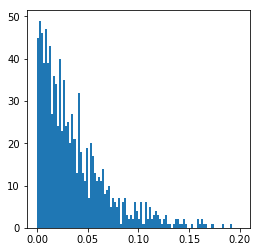

0.0375210296732071


In [17]:
plt.figure(figsize=(4.,4.))

plt.hist(q_threshold_uncertainties[0], 100, range=[0.,.2])

plt.show()

print(np.mean(q_threshold_uncertainties[0]))

# Likelihood ratio histograms

In [ ]:
this_range = (-2.,1.)
this_bins  = 50

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]), range=this_range, bins=this_bins, color=colors[i], alpha=0.1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]), range=this_range, bins=this_bins, color=colors[i], histtype='step',
                 label=labels[s])
        
    plt.hist(np.log(r_benchmark[truth_index]), range=this_range, bins=this_bins, color='black', histtype='step',
             label=labels[truth_index])
    
    plt.legend(loc='upper left')
    
    plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
    plt.xlim(this_range[0],this_range[1])

plt.tight_layout()
plt.savefig("../figures/results/r_histograms_" + main_mode + ".pdf")

# Benchmark theta: approximate vs exact r(x)

In [ ]:
xmin = -3.
xmax = 0.6
skip = 100

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)

    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                    np.log(r_benchmark[s][::skip]),
                    marker='o', alpha=0.3, s=10., c=colors[i], lw=0.,
                    label=labels[s])
        
    plt.legend(loc='lower right')
    
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
    plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")

plt.tight_layout()
plt.savefig("../figures/results/r_scatter_" + main_mode + ".pdf")

# Benchmark thetas: histograms of errors on log r

In [ ]:
this_range = (-.5,.5)
this_bins  = 50

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]) - np.log(r_benchmark[truth_index]),
                 range=this_range, bins=this_bins, color=colors[i], alpha=0.1)
        
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]) - np.log(r_benchmark[truth_index]),
                 range=this_range, bins=this_bins, color=colors[i], histtype='step',
                 label=labels[s])
        
    plt.legend(loc='upper left')
    plt.xlabel(r'Error $\log \ \hat{r}(x; \theta_0, \theta_1) - \log \ r(x; \theta_0, \theta_1)$')
    plt.xlim(this_range[0], this_range[1])
    
plt.tight_layout()
plt.savefig("../figures/results/r_error_histograms_" + main_mode + ".pdf")

# Benchmark theta: error on log r vs max(p0, p1)

In [ ]:
xmin, xmax = -0.5, 0.5
skip = 100

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(np.maximum(p0_benchmark[truth_index], p1[truth_index])[::skip],
                    np.log(r_benchmark[truth_index][::skip]) - np.log(r_benchmark[s][::skip]),
                    marker='o', alpha=scatter_alpha, s=10., c=colors[i], lw=0.,
                    label=labels[s])
        
    plt.legend(loc='lower right')
    
    ax.set_xscale("log", nonposx='clip')
    plt.xlim(3.e-6,1.e-3)
    plt.ylim(xmin,xmax)
    
    plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
    plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")

plt.tight_layout()
plt.savefig("../figures/results/r_error_vs_pmax_" + main_mode + ".pdf")

# Exact vs approximate expected log likelihood ratios

In [ ]:
xmin, xmax = -10., 30.
skip = 2

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(expected_llr[truth_index][::skip], expected_llr[s][::skip],
                    marker='o', color=colors[i], alpha=scatter_alpha, 
                    s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::skip]],
                    lw=0.,
                    label=labels[s])
        
    plt.legend(loc='upper left')
    
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
    plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")

plt.tight_layout()
plt.savefig("../figures/results/expected_likelihood_scatter_" + main_mode + ".pdf")

# Error on log r expectation over theta

In [ ]:
zmin, zmax = -10., 10.
n_rows = math.ceil((len(labels) - 1) / 3.)

fig = plt.figure(figsize=(15.,n_rows*4.))

panel = 0 
for i, (label, err) in enumerate(zip(labels, expected_llr_errors)):
    if i == truth_index:
        continue
    panel += 1
        
    ax = plt.subplot(n_rows, 3, panel)
    
    if ('PbP' in label) or ('AFC' in label):
        plt.scatter(thetas[::,0], thetas[::,1], c=err[::],
                    s=25.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
        plt.scatter(thetas[pbp_training_thetas,0], thetas[pbp_training_thetas,1], c=err[pbp_training_thetas],
                    s=100.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
    else:
        plt.scatter(thetas[::,0], thetas[::,1], c=err[::],
                    s=40.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
    
    if len(thetas_highlighted) > 0:
        plt.scatter(thetas[thetas_highlighted,0], thetas[thetas_highlighted,1], c=err[thetas_highlighted],
                    s=150.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    
    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$E[\log \ \hat{r}] - E[\log \ r]$ (' + label + ')')
    
plt.tight_layout()
plt.savefig("../figures/results/expected_likelihood_errors_over_theta_" + main_mode + ".pdf")

# Benchmark thetas: exact vs approximate score

In [ ]:
skip = 100
xmin, xmax = -1., 3.

fig = plt.figure(figsize=(12.,8.))

for actual_panel, panel in enumerate([0,1,3]):
        
    for component in range(2):
        ax = plt.subplot(2,3,actual_panel+1 + component*3)

        plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')

        for i, s in enumerate(panel_indices[panel]):
            if scores_benchmark[s] is not None:
                plt.scatter(scores_benchmark[truth_index][::skip, component],
                            scores_benchmark[s][::skip, component],
                            marker='o', alpha=scatter_alpha, s=15., c=colors[i], lw=0.,
                            label=labels[s])

        plt.legend(loc='lower right')

        plt.xlim(xmin, xmax)
        plt.ylim(xmin, xmax)

        plt.xlabel(r"True $t_" + str(component) + "(x|\theta_0)$")
        plt.ylabel(r"Learned $\hat{t}_" + str(component) + "(x|\theta_0)$")

plt.tight_layout()
plt.savefig("../figures/results/score_scatter_" + main_mode + ".pdf")

# Theta dependence

In [ ]:
rmin, rmax = -1.1,0.6
r_lines = [-1.,-0.5,0.,0.5]

n_roaming = 10
show_roaming = [1,6,7,11]
n_roaming_show = len(show_roaming)

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

n_strategies_shown = sum([r is not None for r in r_roam])

fig = plt.figure(figsize=(5.*n_roaming_show, 4.*n_strategies_shown))

i = 0
for s, (r, l) in enumerate(zip(r_roam, labels)):
    
    if r is None:
        continue
        
    for j in range(n_roaming_show):
        ax = plt.subplot(n_strategies_shown, n_roaming_show, 1 + n_roaming_show*i + j)
        
        #zi = np.clip(np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam))), rmin, rmax)
        zi = np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))

        cs = plt.contourf(xi, yi, zi,
                          100, cmap="viridis", vmin=rmin, vmax=rmax)
        cbar = plt.colorbar()
        plt.contour(xi, yi, zi,
                    r_lines,
                    linewidths=1., colors='white',
                    linestyles='solid')

        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        if s == truth_index:
            cbar.set_label(r'True $\log r(x_' + str(j) + r'; \theta, \theta_1)$ (' + l + ')')
        else:
            cbar.set_label(r'Learned $\log \hat{r}(x_' + str(j) + r'; \theta, \theta_1)$ (' + l + ')')
        
    i += 1

plt.tight_layout()
plt.savefig("../figures/results/theta_dependence_comparison_" + main_mode + ".pdf")

# Benchmark theta: x dependence

In [ ]:
skip = 50

n_columns = math.ceil(len(r_benchmark) / 3.)

fig = plt.figure(figsize=(15.,4. * n_columns))

for i, (r, l) in enumerate(zip(r_benchmark, labels)):
    
    ax = plt.subplot(n_columns, 3, i + 1)

    plt.scatter(X_observed[::skip,1],
                X_observed[::skip,41],
                c=np.log(r[::skip]),
                vmin=-1., vmax=0.5,
                marker='o', s=20., lw=0.)
    cbar = plt.colorbar()
    
    plt.xlim(20.,500.)
    plt.ylim(0.,math.pi)
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    if i == truth_index:
        cbar.set_label(r'$r(x)$ (' + l + ')')
    else:
        cbar.set_label(r'$\hat{r}(x)$ (' + l + ')')

plt.tight_layout()
plt.savefig('../figures/results/x_dependence_' + main_mode + '.pdf')

# Expected LLR contours

In [ ]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

llr_lines = [4.,16.]

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2, 2, panel+1)

    cs = plt.contour(xi, yi, interpolated_expected_llr[truth_index], llr_lines,
                     linewidths=1.5, colors='black',
                     linestyles=['solid','dashed'])
    cs.collections[0].set_label(labels[truth_index])
        
    for i, s in enumerate(panel_indices[panel]):
        cs = plt.contour(xi, yi, interpolated_expected_llr[s], llr_lines,
                         linewidths=1.5, colors=colors[i],
                         linestyles=['solid','dashed'])
        cs.collections[0].set_label(labels[s])

    plt.scatter([xi[interpolated_expected_llr_mle[truth_index][1]]],
                [yi[interpolated_expected_llr_mle[truth_index][0]]],
                marker='o', c='black', s=50, lw=0, zorder=10)
        
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[i], s=50, lw=0, zorder=10)

    plt.legend(loc='upper left')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

plt.tight_layout()
plt.savefig("../figures/results/likelihood_contours_" + main_mode + ".pdf")

# Individual LLR outputs for debugging

In [ ]:
i = truth_index

plt.figure(figsize=(8.,6.7))

zi = np.clip(interpolated_expected_llr[i],0.,25.)

cs = plt.contourf(xi, yi, zi, 100, vmin=0.,vmax=25., cmap='viridis_r')

cs = plt.contour(xi, yi, zi, [1,4,9,16],
                 linewidths=[3.,2.,2.,2.], colors='w',
                 linestyles=['dotted', 'solid', 'dashed', '-.'])
cs.collections[0].set_label(r'$E[q(\theta)] = 1^2$')
cs.collections[1].set_label(r'$E[q(\theta)] = 2^2$')
cs.collections[2].set_label(r'$E[q(\theta)] = 3^2$')
cs.collections[3].set_label(r'$E[q(\theta)] = 4^2$')

plt.scatter(thetas[:,0], thetas[:,1],
            c=expected_llr[i] - min(expected_llr[i][:]),
            s=200., lw=1., cmap='viridis_r', edgecolors='k',
            vmin=0., vmax=25.)
cbar = plt.colorbar()

plt.legend(loc='lower right')

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)

plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Expected $q(\theta)$ (truth)')

plt.tight_layout()
plt.savefig("../figures/results/likelihood_contour_truth.pdf")

In [ ]:
i = 10
print(labels[i])

plt.figure(figsize=(8.,6.7))

zi = np.clip(interpolated_expected_llr[i],0.,25.)

cs = plt.contourf(xi, yi, zi, 100, vmin=0.,vmax=25., cmap='viridis_r')

cs = plt.contour(xi, yi, zi, [1,4,9,16],
                 linewidths=[3.,2.,2.,2.], colors='w',
                 linestyles=['dotted', 'solid', 'dashed', '-.'])
cs.collections[0].set_label(r'$E[q(\theta)] = 1^2$')
cs.collections[1].set_label(r'$E[q(\theta)] = 2^2$')
cs.collections[2].set_label(r'$E[q(\theta)] = 3^2$')
cs.collections[3].set_label(r'$E[q(\theta)] = 4^2$')

plt.scatter(thetas[:,0], thetas[:,1],
            c=expected_llr[i] - min(expected_llr[i][:]),
            s=200., lw=1., cmap='viridis_r', edgecolors='k',
            vmin=0., vmax=25.)
cbar = plt.colorbar()

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)

plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Expected $q(\theta)$ (score regression)')

plt.tight_layout()
plt.savefig("../figures/results/likelihood_contour_scoreregression.pdf")

# CL contours from Neyman construction

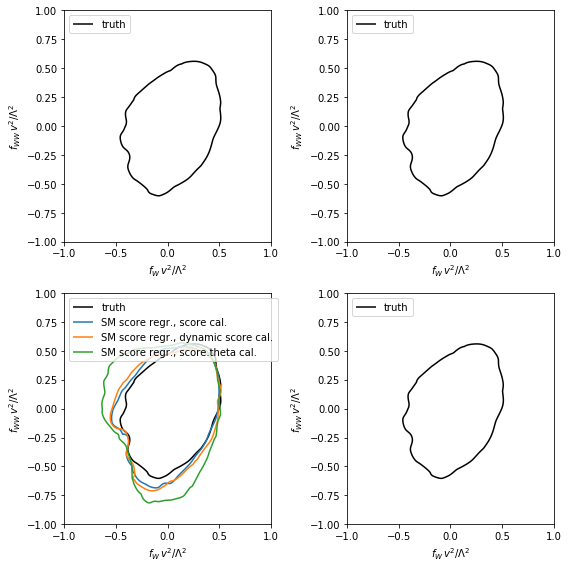

In [20]:
cl_lines = [0.001,0.05,0.3]

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2, 2, panel+1)

    cs = plt.contour(xi, yi, interpolated_95cl_excluded[truth_index], [0.],
                     linewidths=1.5, colors='black',
                     linestyles='solid')
    cs.collections[0].set_label(labels[truth_index])
        
    i = 0
    for s in panel_indices[panel]:
        if interpolated_p_values[s] is None:
            continue
        
        cs = plt.contour(xi, yi, interpolated_95cl_excluded[s], [0.],
                         linewidths=1.5, colors=colors[i],
                         linestyles='solid')
        cs.collections[0].set_label(labels[s])
        
        i += 1

    plt.legend(loc='upper left')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

plt.tight_layout()
plt.savefig("../figures/results/cl_contours_" + main_mode + ".pdf")

# Individual p-value plots for debugging

truth
SM score regr., score cal.
SM score regr., dynamic score cal.
SM score regr., score.theta cal.


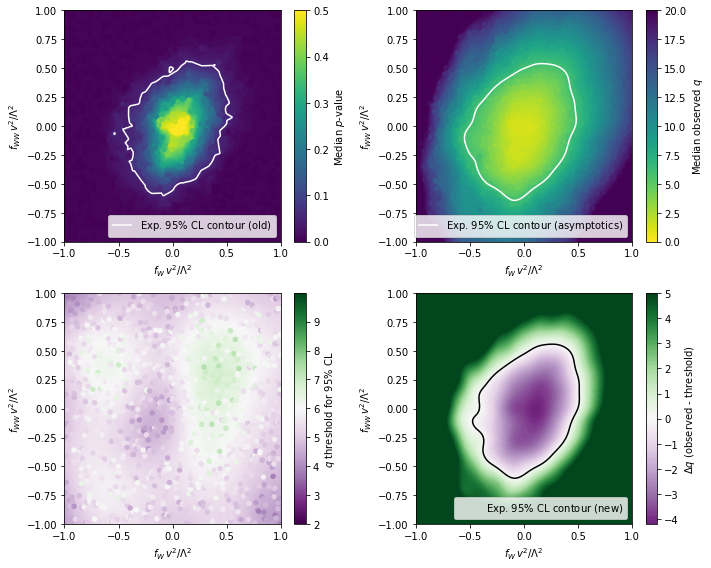

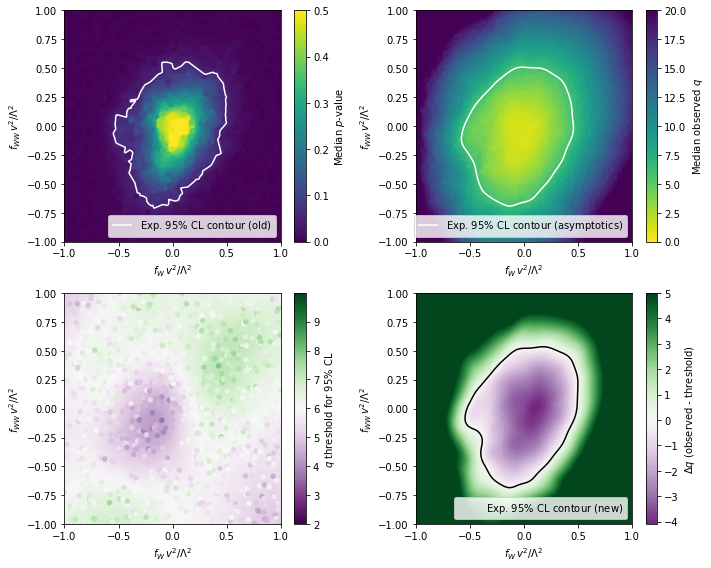

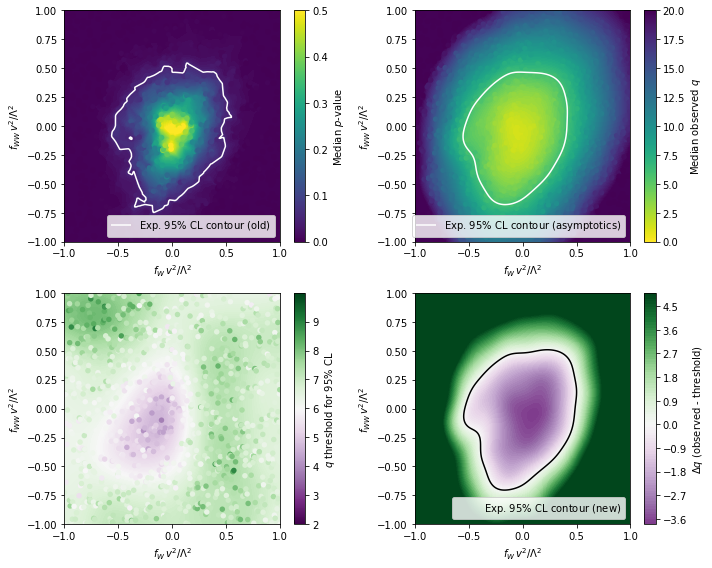

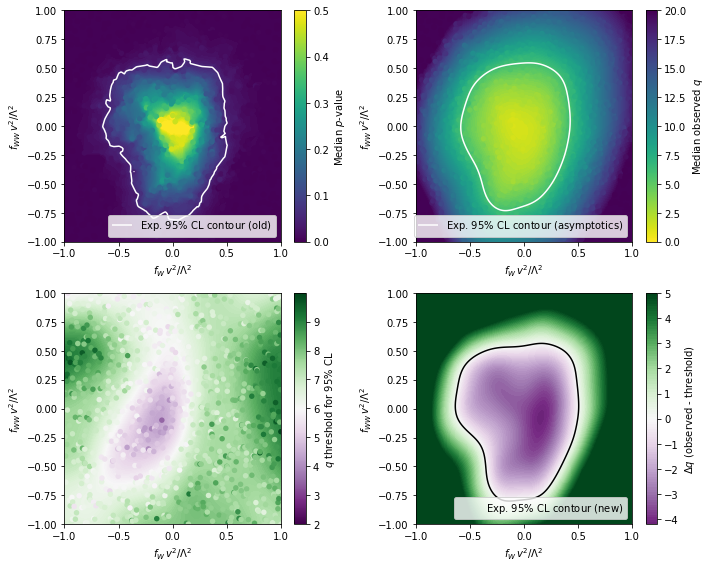

In [28]:
strategies = [truth_index,9,10,11]

for i in strategies:
    print(labels[i])
    
    plt.figure(figsize=(10,8))

    plt.subplot(2,2,1)
    zmin, zmax = 0.,0.5
    cs = plt.contourf(xi, yi, interpolated_p_values[i], 100, cmap='viridis',
                     vmin=zmin, vmax=zmax)
    cs = plt.contour(xi, yi, interpolated_p_values[i], [0.05],
                     linewidths=1.5, colors='w',
                     linestyles='solid')
    cs.collections[0].set_label('Exp. $95 \%$ CL contour (old)')
    plt.scatter(thetas[:,0], thetas[:,1],
                c=p_values[i],
                s=30., lw=0., cmap='viridis', edgecolors='k',
                vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    plt.legend(loc='lower right')
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('Median $p$-value')

    plt.subplot(2,2,2)
    zmin, zmax = 0.,20.
    zi = np.clip(interpolated_q_medians[i],zmin,zmax)
    cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r',
                     vmin=zmin, vmax=zmax)
    plt.scatter(thetas[:,0], thetas[:,1],
                c=q_medians[i],
                s=30., lw=0., cmap='viridis_r', edgecolors='k',
                vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    cs = plt.contour(xi, yi, zi, [5.991464547107982],
                     linewidths=1.5, colors='w',
                     linestyles='solid')
    cs.collections[0].set_label('Exp. $95 \%$ CL contour (asymptotics)')
    plt.legend(loc='lower right')
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('Median observed $q$')

    plt.subplot(2,2,3)
    zmin, zmax = 5.991464547107982 - 4., 5.991464547107982 + 4.
    zi = np.clip(interpolated_q_thresholds[i], zmin, zmax)
    cs = plt.contourf(xi, yi, zi, 100, cmap='PRGn',
                     vmin=zmin, vmax=zmax)
    plt.scatter(thetas[:,0], thetas[:,1],
                c=q_thresholds[i],
                s=30., lw=0., cmap='PRGn', edgecolors='k',
                vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('$q$ threshold for $95\%$ CL')

    plt.subplot(2,2,4)
    zmin, zmax = -5.,5.
    zi = np.clip(interpolated_95cl_excluded[i], zmin+0.01, zmax-0.01)
    cs = plt.contourf(xi, yi, zi, 100, cmap='PRGn',
                     vmin=zmin, vmax=zmax)
    cbar = plt.colorbar(cs)
    plt.contour(xi, yi, zi, [0.],
                     linewidths=1.5, colors='k',
                     linestyles='solid')
    cs.collections[0].set_label('Exp. $95 \%$ CL contour (new)')
    plt.legend(loc='lower right')
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('$\Delta q$ (observed - threshold)')

    plt.tight_layout()
    plt.savefig("../figures/neyman/cl_contour_" + suffices[i] + ".pdf")